<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных-(EDA)" data-toc-modified-id="Исследовательский-анализ-данных-(EDA)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных (EDA)</a></span></li><li><span><a href="#Модель-прогнозирования-оттока-клиентов" data-toc-modified-id="Модель-прогнозирования-оттока-клиентов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель прогнозирования оттока клиентов</a></span></li><li><span><a href="#Кластеризация-клиентов" data-toc-modified-id="Кластеризация-клиентов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Кластеризация клиентов</a></span></li><li><span><a href="#Общие-выводы-и-рекомендации" data-toc-modified-id="Общие-выводы-и-рекомендации-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общие выводы и рекомендации</a></span></li></ul></div>

# Прогнозирование оттока клиентов сети фитнес-центров

## Обзор данных

Импортируем необходимые для работы библиотеки.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

Откроем файл с данными и изучим общую информацию.

In [2]:
gym_churn = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
# распечатаем первые 5 строк датасета
gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
# получение сводной информации о полученном датасете
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Согласно документации к данным таблица `gym_churn` содержит:
* `Churn` — факт оттока в текущем месяце;

Текущие поля в датасете:

Данные клиента за предыдущий до проверки факта оттока месяц:
* `gender` — пол;
* `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
* `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* `Phone` — наличие контактного телефона;
* `Age` — возраст;
* `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
* `Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
* `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
* `Group_visits` — факт посещения групповых занятий;
* `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
* `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
* `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

***Вывод***

Данные были успешно извлечены из файла и мы определили, что пропущенных значений в таблице нет, поля датасета имеют соответствующий формат данных. Также мы изучили содержание полей полученной таблицы с информацией о клиентах фитнес-клуба. Названия столбцов датасета можно привести к единому представлению в нижнем регистре для удобства использования в дальнейшем исследовании.

## Исследовательский анализ данных (EDA)

Проведем первоначальный анализ данных для оценки типа и качества признаков, их распределений и взаимных корреляций.

In [5]:
# приведем названия столбцов к нижнему регистру
gym_churn.columns= gym_churn.columns.str.lower()

In [6]:
# распечатаем размер датасета
print(gym_churn.shape)

(4000, 14)


In [7]:
# распечатаем первые 5 строк датасета
gym_churn.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Таблица с данными состоит из 4000 наблюдений и 14 полей признаков. Поля признаков делятся на числовые и категориальные. 

Числовые признаки:
1. `age`
2. `avg_additional_charges_total`
3. `month_to_end_contract`
4. `lifetime`
5. `avg_class_frequency_total`
6. `avg_class_frequency_current_month`

Категориальные признаки:
1. `gender`
2. `near_location`
3. `partner`
4. `promo_friends`
5. `phone`
6. `contract_period`
7. `group_visits`
8. `churn`

Категориальная переменная `contract_period` может принимать одно из 3 значений (классов): `1`, `6`, `12`, а категориальное поле `gender` — `1` или `0` (допустим, что `1` — мужчина, `0` — женщина). Категориальная переменная `churn`, описывающая факт оттока клиента, принимает также два значения: `1` — клиент ушел (перестал пользоваться сервисом), `0` — клиент остался (продолжает пользоваться сервисом). Остальные категориальные поля также представлены двумя классами значений: `1` (есть признак) и `0` (нет признака). Здесь можно обозначить, что целевой переменной для нас является категориальная переменная `churn`.

Отсутствующих значений в признаках не обнаружено.

Посмотрим на средние значения и стандартные отклонения числовых признаков.

In [8]:
# выделение числовых полей
num_columns = ['age', 
           'avg_additional_charges_total', 
           'month_to_end_contract', 
           'lifetime',
           'avg_class_frequency_total', 
           'avg_class_frequency_current_month']

# выделение категориальных полей
cat_columns = ['gender',
            'near_location',
            'partner',
            'promo_friends',
            'phone',
            'contract_period',
            'group_visits',
            'churn']

# датасет с числовыми значениями признаков
gym_num_columns = gym_churn[num_columns]
# числовое описание данных полученного датасета
gym_num_columns.describe()

,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052
std,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906
min,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000
25%,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003
50%,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574
75%,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336
max,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783


По этой информации мы получили представление о средних значениях численных признаков клиентов и можем также заметить высокие значения страндартного отклонения для полей `avg_additional_charges_total`, `month_to_end_contract`, `lifetime`, `avg_class_frequency_total` и `avg_class_frequency_current_month` относительно их средних значений. Что означает, что в полях есть аномалии или выбивающиеся значения. Также это может говорить о том, что данные признаков необходимо будет стандартизировать перед обучением моделей прогнозирования для приведения их к одному масштабу.

Аномальные значения также мы можем пояснить следующим образом. Некоторые пользователи могли тратить больше средств на дополнительные услуги фитнес-центра, чем основная масса клиентов. У части пользователей действие абонемента только началось, а у других подходит к концу. Здесь же видим клиентов, у которых лайфтайм достаточно большой, что возможно, если текущий абонемент для клиента не первый и он пользуется услугами центра несколько лет. Наконец, средняя частота в неделю для клиентов может разниться: большинство посещает фитнес-клуб пару раз в неделю, а небольшая часть может приходить каждый день. 

Таким образом, необъяснимо аномальных значений выявлено не было и можно придти к выводу, что обнаруженные выбивающиеся значения имеют место быть в реальной жизни и не являются ошибками.

Кроме того, по полученным данным мы можем составить представление о среднестатистическом клиенте фитнес-клуба. Это клиент около 30 лет, посещающий фитнес-клуб в среднем около 2 раз в неделю, имеющий небольшой лайфтайм (3-5) и короткий по длительности абонемент (1-3).

Теперь посмотрим на средние значения числовых признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [9]:
# группируем по факту оттока, считаем среднее значение
# для числовых полей
gym_churn_mean = gym_churn.groupby('churn').apply(lambda x: x.mean())[num_columns]
gym_churn_mean

,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,
0,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


По полученным средним значениям признаков для двух групп мы можем сказать, что показатели клиентов, покинувших сервис, ниже, чем тех кто остался. Это касается среднего возраста клиента, трат на дополнительные услуги, среднего количества посещений. Лайфтайм ушедших пользователей в среднем тоже ниже, как и количество месяцев до окончания абонемента.

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток). Так мы можем еще раз проверить значения признаков на аномалии и понять как ведет себя каждый из них.

In [10]:
# записываем в датасет только строки с теми, кто остался
gym_churn_stay = gym_churn.query("churn == '0'")
# записываем в датасет только строки с теми, кто ушел
gym_churn_leave = gym_churn.query("churn == '1'")

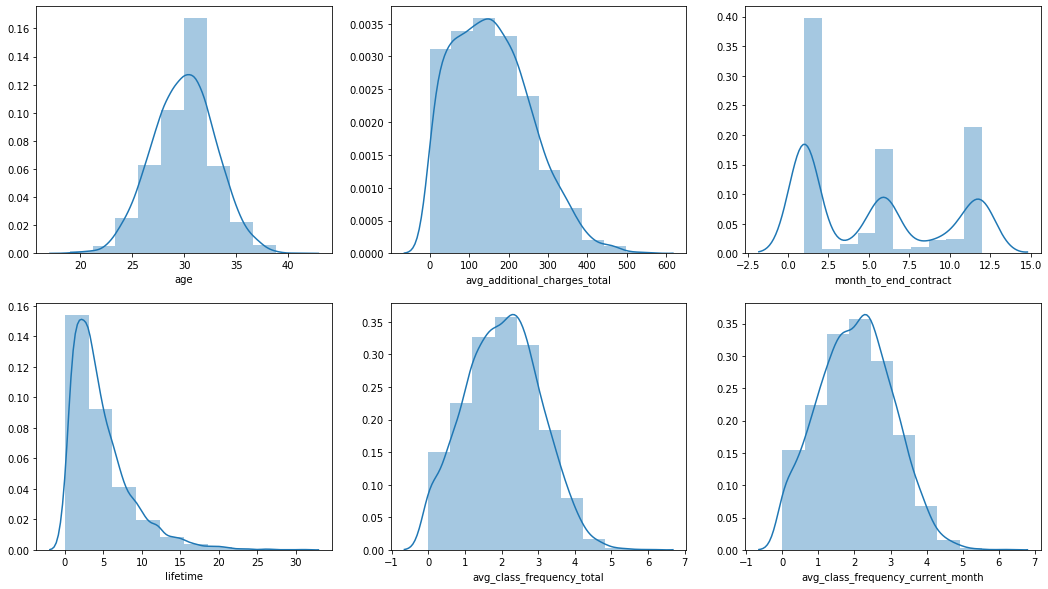

In [11]:
# строим гистограммы распределения для числовых
# признаков для группы не попавших в отток
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(18, 10))

for feature, ax in zip(num_columns, axes.flat):
    sns.distplot(gym_churn_stay[feature], bins=10, ax=ax)    

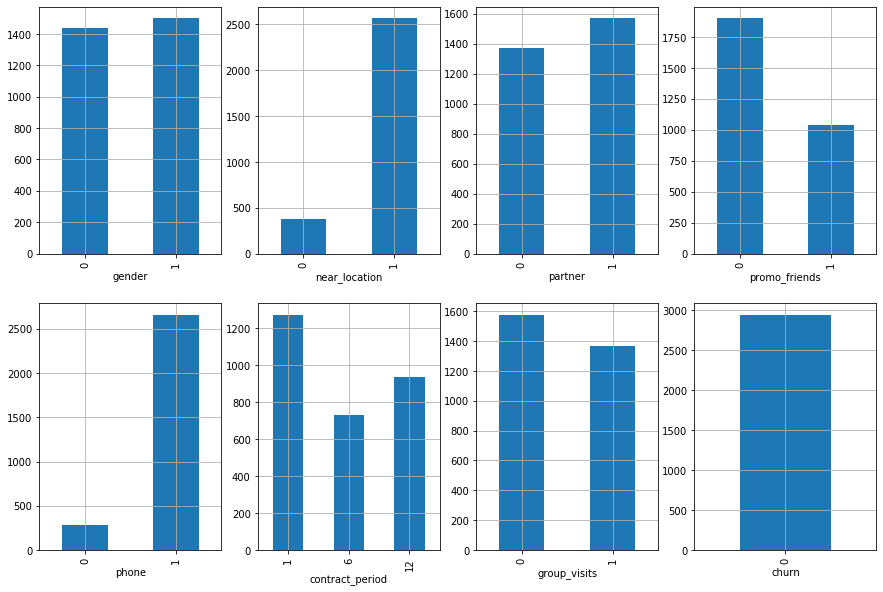

In [12]:
# строим столбчатые диаграммы для категориальных
# признаков для группы не попавших в отток
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(18, 10))

for feature, ax in zip(cat_columns, axes.flat):
    gym_churn_stay.groupby(feature)[feature].count().plot(kind='bar', 
                grid=True, 
                figsize=(15, 10), 
                legend=False, 
                ax=ax)

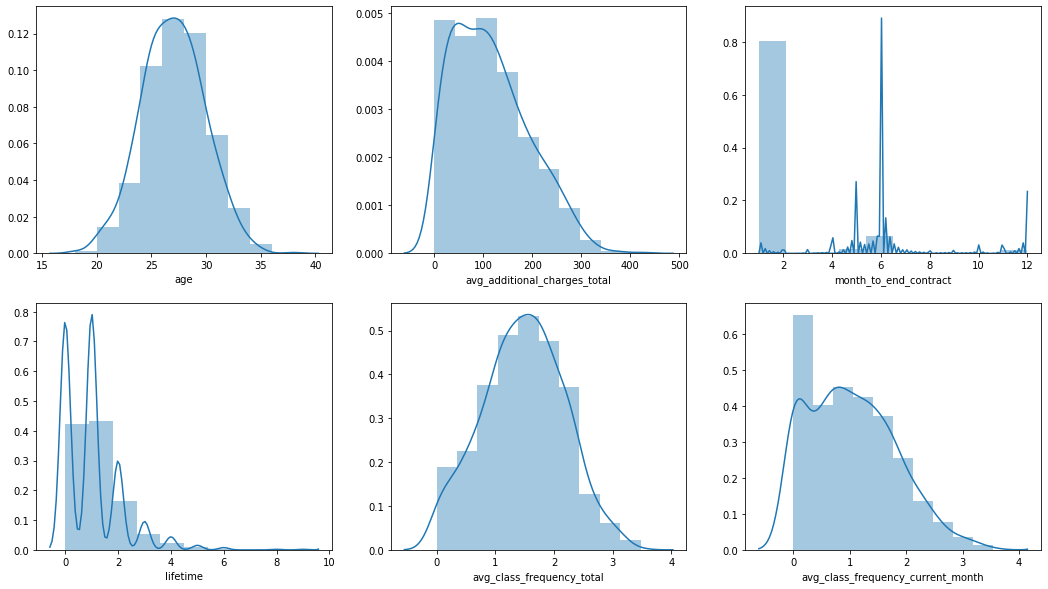

In [13]:
# строим гистограммы распределения для числовых
# признаков для группы попавших в отток
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(18, 10))

for feature, ax in zip(num_columns, axes.flat):
    sns.distplot(gym_churn_leave[feature], bins=10, ax=ax)   

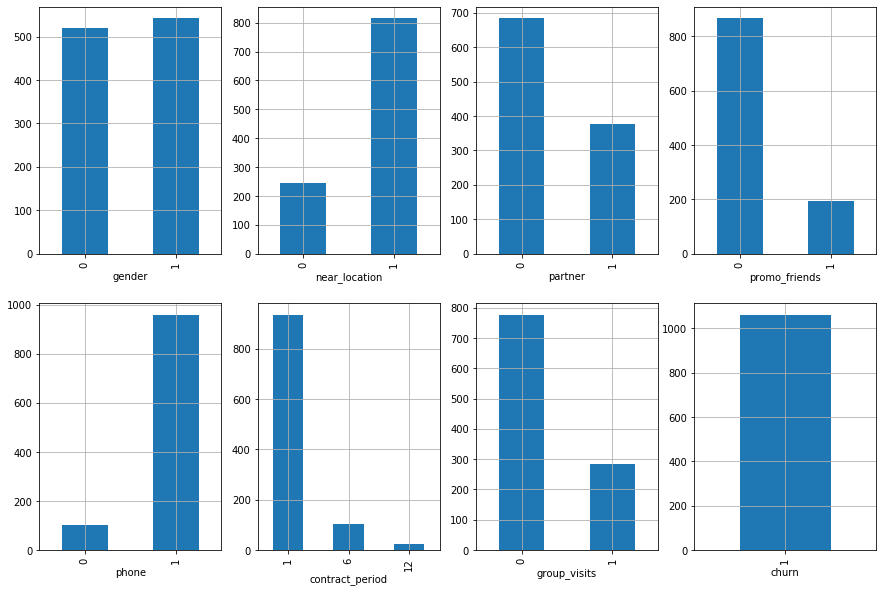

In [14]:
# строим столбчатые диаграммы для категориальных
# признаков для группы попавших в отток
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(18, 10))

for feature, ax in zip(cat_columns, axes.flat):
    gym_churn_leave.groupby(feature)[feature].count().plot(kind='bar', 
                grid=True, 
                figsize=(15, 10), 
                legend=False, 
                ax=ax)

Численные признаки ведут себя нормально или близко к нормальному, а категориальные признаки принимают только известные значения из классов.

Также взгляд на гистограммы позволил составить общее впечатление о клиентах, которые остались и которые покинули сервис. Например, возраст и лайфтайм основной массы оставшихся чуть выше чем у тех кто ушел. Те кто остался посещали центр за весь срок чаще, чем те кто покинул сервис. Соотношение попавших в отток клиентов по полу не отличается от тех кто остался: доля `gender "1"` чуть выше в обоих выборках. А доля клиентов, являющиеся сотрудниками компаний-партнеров, в группе не попавших в отток выше, чем в группе тех кто ушел.

Вычислим матрицу корреляций для всех признаков и отобразим ее.

In [15]:
# построение матрицы корреляций
cm = gym_churn.corr() 
cm

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


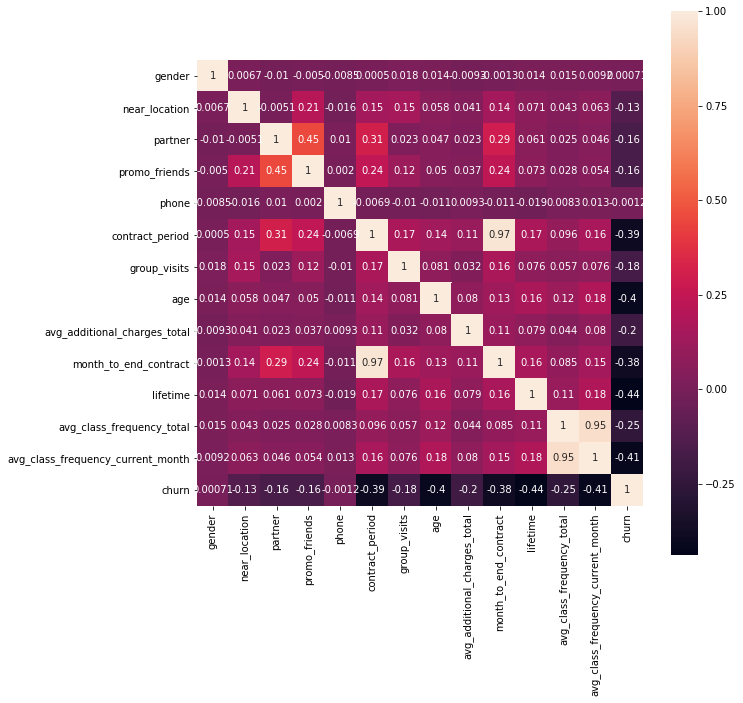

In [16]:
fig, ax = plt.subplots(figsize=(10,10))

# нарисуем тепловую карту с подписями для матрицы корреляций
ax = sns.heatmap(cm, annot = True, square=True)
plt.show()

Здесь видим, что с целевой переменной `churn` остальные признаки не коррелируют. А вот признаки `month_to_end_contract` и `contract_period` достаточно сильно коррелируют между собой, как и признаки `avg_class_frequency_total` и 	`avg_class_frequency_current_month`. 

***Вывод***

В рамках исследовательского анализа данных мы провели первоначальный анализ данных о клиентах фитнес-центра для оценки типа и качества признаков, их распределений и взаимных корреляций. Мы разделили признаки на численные и категориальные. Для численных признаков мы изучили средние значения и стандартные отклонения, выделили аномальные значения и пояснили их наличие. Отсутствующие значения не были обнаружены. Более подробно мы изучили качество и распределение признаков построив гистограммы для клиентов двух групп: которые остались и которые покинули фитнес-центр. Это позволило составить общую картину о каждой категории клиентов сервиса. Также мы построили матрицу корреляции для всех признаков из датасета, подкрепив ее тепловой картой. Было обнаружено что с целевой переменной `churn` остальные признаки не коррелируют.

## Модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце `churn`.

Будем использовать обучение с учителем для задачи бинарной классификации и сравним модели, обученные алгоритмами логической регрессии и случайного леса. В качестве метрик для сравнения моделей будем использовать следующие:
* `Accuracy` — доля правильных ответов из всех прогнозов. Чем ближе значение accuracy к 100%, тем лучше.
* `Precision` — показывает долю правильных ответов только среди целевого класса. 
* `Recall` — показывает сколько реальных объектов целевого класса смогли обнаружить с помощью модели.
* `ROC_AUC` — предсказывает вероятность того, что наблюдение принадлежит к классу "0" или "1". Метрика ROC_AUC содержит в себе максимальное количество информации относительно качества модели.

Для метрики `accuracy`, в отличие от метрик `recall` и `precision`, для оценки модели важно соотношение классов в выборке, поэтому проверим наш набор данных.

In [17]:
# посмотрим, как соотносятся классы набора данных
print('Соотношение классов:\n', gym_churn['churn'].value_counts())

Соотношение классов:
 0    2939
1    1061
Name: churn, dtype: int64


Видим достаточное количество экземпляров каждого класса. Теперь выделим из наших данных признаки и целевую переменную, разделим выборку и приступим к обучению моделей.

In [18]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym_churn.drop(columns=['churn'], axis=1)
y = gym_churn['churn']

In [19]:
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

Используем стандартизацию, чтобы привести значения признаков к виду стандартного нормального распределения: значения будут центрированы относительно 0, а средний разброс данных составит 1.

In [20]:
# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
# обучаем StandartScaler на обучающей выборке
scaler.fit(X_train)
# применяем стандартизацию к матрице признаков для обучающей и валидационной выборки
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Для отображения метрик классификации для каждой модели создадим отдельную функцию с методами метрик.

In [21]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_test, y_proba)))

Обучим модель на  обучающей выборке двумя способами: логистической регрессией (`sklearn.linear_model.LogisticRegression()`) и 
случайным лесом (`sklearn.ensemble.RandomForestClassifier()`).

In [22]:
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(solver = 'liblinear', random_state = 0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st) 
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)

Метрики для модели логистической регрессии:
	Accuracy: 0.94
	Precision: 0.90
	Recall: 0.85
	ROC_AUC: 0.98
Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.88
	Recall: 0.83
	ROC_AUC: 0.97


На основании метрик модели логистической регрессии и случайного леса показали себя в прогнозах одинаково хорошо. `Accuracy` и метрика качества модели `ROC-AUC` более 90%. Разница в метриках `Recall` и `Precision` 1-2%, то есть незначительная.

Мы можем также провести анализ важности признаков модели (`feature importance`). Проверим важность признаков на модели случайного леса.

In [23]:
# создадим датафрейм с именами признаков и их важностью и выведем его по убыванию важности
importances = list(rf_model.feature_importances_)
d = {'col1': importances}
data=pd.DataFrame(data=d)
display(data.sort_values(by='col1', ascending=False))

,col1
10,0.270336
12,0.176142
11,0.135955
7,0.121477
8,0.088327
9,0.072941
5,0.067406
6,0.016090
0,0.012293
2,0.012099


Модель случайного леса посчитала важными при расчёте прогноза важными признаки `lifetime` (коэффициент 0.27), `avg_class_frequency_current_month` (коэффициент 0.18), `avg_class_frequency_total` (коэффициент 0.12), `age` (коэффициент 0.11).

***Вывод***

Мы построили модель бинарной классификации клиентов с целевым признаком факта оттока клиента в следующем месяце. Мы использовали обучение с учителем и использовали алгоритмы логической регрессии и случайного леса для обучения наших моделей. Для оценки качества обученных моделей мы рассчитывали метрики `Accuracy`(доля правильных ответов), `Precision` (точность), `Recall` (полнота) и `ROC_AUC` (вероятность верного прогноза). В результате мы сравнили обученные модели по метрикам и выяснили, что модели логистической регрессии и случайного леса показали в прогнозе оттока клиентов себя одинаково хорошо. `Accuracy` и метрика качества модели `ROC-AUC` для них поставила более 90%. Кроме того, мы оценили важность признаков на примере модели, обученной алгоритмом случайного леса, и обнаружили что признаки `lifetime`, `avg_class_frequency_current_month`, `avg_class_frequency_total`, `age` являлись наиболее важными при прогнозе.

## Кластеризация клиентов

Проведем кластеризацию клиентов - попробуем выделить группы (сегменты) клиентов по схожести их признаков.

In [24]:
# выделим только признаки клиентов
X = gym_churn.drop(columns=['churn'], axis=1)
display(X.head())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078


Теперь получим стандартизированную матрицу признаков.

In [25]:
# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(X)

Построим матрицу расстояний, используя функцию `linkage()` на стандартизованной матрице признаков, и выполним визуализацию с помощью дендрограммы. Так мы сможем визуально оценить, сколько кластеров должно быть.

In [26]:
# получаем таблицу «связок» между объектами
linked = linkage(X_sc, method = 'ward')

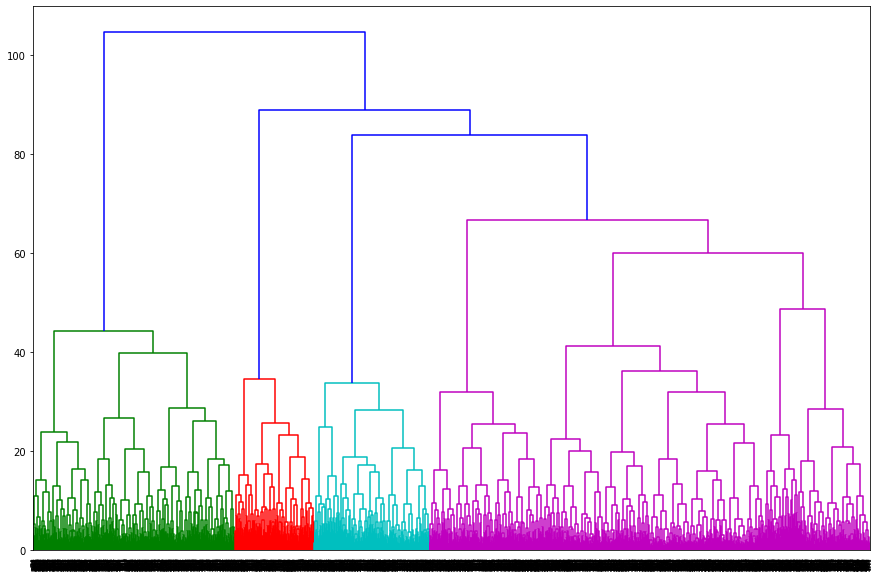

In [27]:
# построение дендрограммы
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

Предложенное в результате оптимальное число кластеров 4 — четыре разных цвета на графике.

Теперь обучим модель кластеризации на основании алгоритма `K-Means` и спрогнозируем кластеры клиентов. По заданному в задании условию примем  за число кластеров n=5.

In [28]:
# задаём число кластеров, равное 5
km = KMeans(n_clusters = 5, random_state=0) 
# применяем алгоритм к данным и формируем вектор кластеров
labels = km.fit_predict(X_sc)

In [29]:
# записываем выделенные индексы кластеров в столбец датафрейма
gym_churn['cluster'] = labels

In [30]:
# вывод на экран 5 строк датафрейма
display(gym_churn.head())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,1
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0,3
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0,3


In [31]:
# определяем количество кластеров
gym_churn['cluster'].value_counts()

3    1262
0    1011
4     837
2     505
1     385
Name: cluster, dtype: int64

С помощью алгоритма `K-Means` мы выделили 5 групп клиентов (кластеров). Посмотрим на средние значения признаков для каждого кластера.

In [32]:
# группируем по кластеру и вычисляем средние значения признаков
gym_churn.groupby('cluster').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.502473,0.959446,0.783383,0.574679,1.000000,10.884273,0.543027,29.980218,160.706969,9.950544,4.738872,1.983305,1.976225,0.027695
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.560335,0.976105,0.356033,0.229391,0.998805,2.665472,0.473118,30.127838,161.724258,2.455197,4.896057,2.851531,2.849473,0.068100


Здесь можно заметить, что кластеры 2 и 3 имеют наибольшее среднее значение оттока клиентов, а кластер 0 и 4 - наименьшее. Кластеры с наименьшей долей оттока имеют наибольшие средние значения по признакам `lifetime`, `avg_additional_charges_total`, `age`, `group_visits`, `group_visits` по сравнению с остальными кластерами. 

Теперь построим распределения признаков для выделенных кластеров и посмотрим на них подробнее.

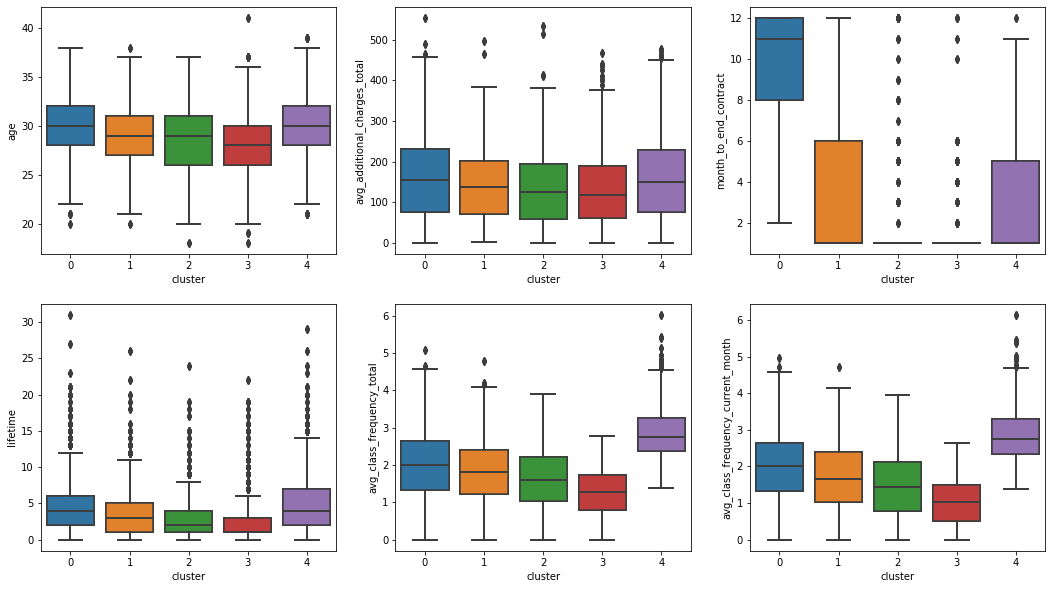

In [33]:
# строим гистограммы распределения числовых признаков по кластерам
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(18, 10))

for feature, ax in zip(num_columns, axes.flat): 
    for data in gym_churn.groupby('cluster')[feature]:
        sns.boxplot(x ='cluster',y = feature, data = gym_churn, ax=ax)

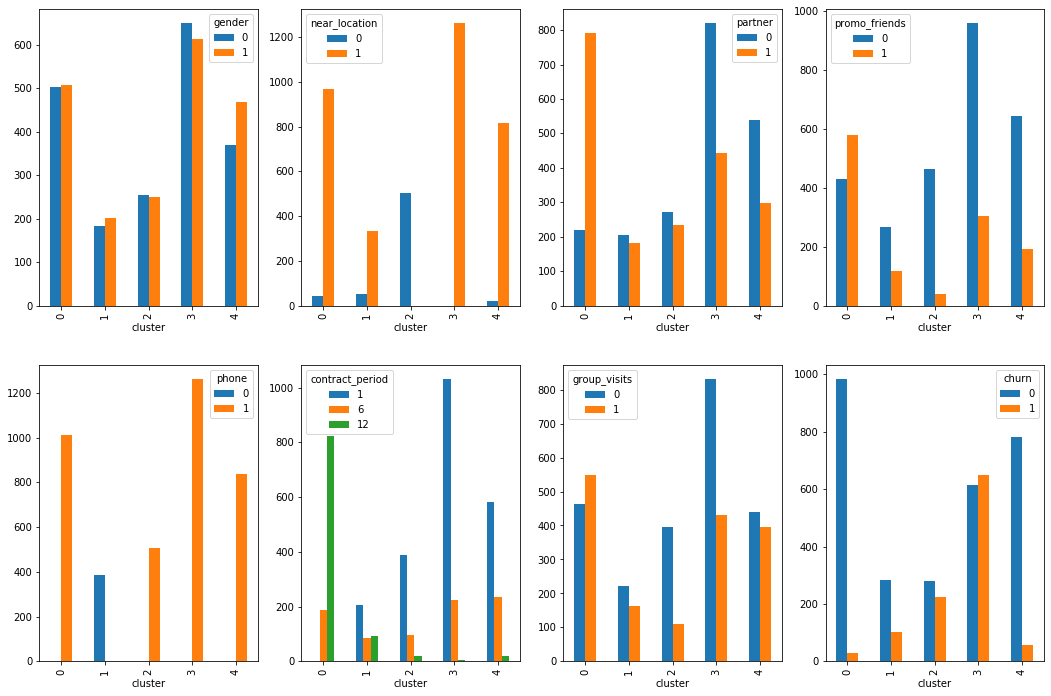

In [34]:
# строим гистограммы распределения категориальных признаков по кластерам
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(18, 12))

for feature, ax in zip(cat_columns, axes.flat):
    gym_churn.groupby(['cluster', feature])[feature].size().unstack(fill_value=0).plot.bar(ax=ax)

Сравним признаки по выделенным кластерам:

***`0 кластер`:***
* высокое значение лайфтайма;
* в основном клиенты проживают или работают рядом;
* являются сотрудниками компании-партнёра клуба; 
* значительная часть пришла в рамках акции "приведи друга"; 
* имеют длительные контракты (12 мес.);
* посещают групповые занятия;
* посещают фитнес-клуб в среднем около 2 раз в неделю; 
* имеют очень низкий отток.

***`1 кластер`:***
* самая немногочисленная группа;
* хороший лайфтайм;
* посещают фитнес-клуб в среднем около 2 раз в неделю;
* в основном клиенты проживают или работают рядом;
* основная часть клиентов не были приглашены в рамках акции "приведи друга";
* нет контактного номера телефона;
* в основном имеют короткие контракты (1 мес);
* примерно только половина клиентов посещает групповые занятия;
* 1/3 клиентов покидают сервис

***`2 кластер`:***
* не проживают или работают рядом;
* основная часть клиентов не были приглашены в рамках акции "приведи друга";
* имеют короткие контракты (1 мес);
* основная масса клиентов не посещают групповые занятия;
* высокий отток

***`3 кластер`:***
* низкое значение лайфтайма клиента;
* посещают фитнес-клуб в среднем около 1 раза в неделю;
* клиенты проживают или работают только рядом;
* в основном не являются сотрудниками компании-партнёра клуба;
* основная часть клиентов не были приглашены в рамках акции "приведи друга";
* имеют короткие контракты (1 мес);
* основная масса клиентов не посещают групповые занятия;
* имеют самый высокий отток 

***`4 кластер`:*** 
* наибольшие траты на дополнительные услуги;
* преобладает gender 1;
* в основном клиенты проживают или работают рядом;
* большая часть является сотрудниками компании-партнёра клуба;
* основная часть клиентов не были приглашены в рамках акции "приведи друга";
* в основном имеют короткие контракты (1 мес);
* около половины клиентов не посещает групповые занятия;
* посещают фитнес-клуб в среднем около 3 раз в неделю;
* низкий отток

Благодаря кластеризации клиентов, мы можем увидеть достаточно четкое разделение по признакам и определить особенности и потребности клиентов, а затем сформулировать рекомендации по их удержанию.

Можно предположить, что клиенты кластера `0` скорее всего постоянные клиенты с длительными контрактами, а клиенты из кластера `4` пользуются короткими контрактами, но посещают чаще остальных и больше тратят на дополнительные услуги фитнес-центра. Кластеры `1`, `2`, `3` имеют значительный отток и клиентов из этих групп необходимо удерживать, разобравшись в причинах оттока. Здесь видим, что проблема оттока клиентов кластера `2` в том, что клиенты не проживают и не работают рядом с фитнес-центром и тратят время и деньги на дорогу. Клиента кластера `1` не оставили контактного телефона и с ними нельзя связаться, чтобы предложить услуги или получить отзыв. Клиенты кластера `2` не являются сотрудниками компании-партнёра и не имеют скидки на абонементы, также они не посещают по какой-то причине групповые занятия и, возможно, поэтому после истечения месячного абонемента не продолжают пользоваться сервисом.

Для каждого описанного выше кластера посчитаем точную долю оттока.

In [35]:
# группируем датасет по кластерам и находим среднее значение оттока
gym_churn_mean = gym_churn.groupby('cluster')[['churn']].mean()
# отдельный столбец для отображения доли в процентах
gym_churn_mean['%'] = round(gym_churn_mean * 100, 2)
# сортировка по убыванию процента оттока
gym_churn_mean.sort_values(by='%', ascending=False)

,churn,%
cluster,,
3,0.514263,51.43
2,0.443564,44.36
1,0.267532,26.75
4,0.068100,6.81
0,0.027695,2.77


Действительно, кластеры отличаются по доле оттока клиентов. Видим, что кластеры `0` и `4` достаточно надежны, их доля оттока минимальна в сравнении с остальными. В свою очередь кластеры `1`, `2`, `3` склонны к оттоку, то есть клиенты из этих групп требуют дополнительного внимания и действий по их удержанию.

***Вывод***

Для того, чтобы выделить группы клиентов по схожести их признаков мы провели их кластеризацию и визуализировали результат с помощью дендрограммы. С помощью алгоритма `K-Means` мы выделили 5 групп клиентов (кластеров), оценили средние значения признаков и построили их распределения. Кроме того, мы описали каждую группу клиентов, посчитали долю оттока для каждого кластера. Это позволило предположить особенности и потребности клиентов и теперь дает возможность сформулировать рекомендации по их удержанию.

## Общие выводы и рекомендации

В нашем исследовании мы прогнозировали вероятность оттока гостей фитнес-центра по предоставленным данным анкет клиентов. Для построения модели бинарной классификации клиентов с целевым признаком факта оттока клиента в следующем месяце были использованы алгоритмы логической регрессии и случайного леса для обучения наших моделей (обучение с учителем). В результате мы сравнили обученные модели по метрикам и выяснили, что обе модели показали в прогнозе оттока клиентов себя одинаково хорошо. Метрика для доли правильных ответов и метрика качества модели для них поставила более 90%. Что позволяет прогнозировать отток клиентов фитнес-центра с высокой точностью по существующим в анкете признакам.

Также мы провели кластеризацию клиентов и выделили 5 клиентов (кластеров). Исследовав особенности каждого кластера, мы описали каждую группу клиентов, сформировали их типичные портреты и посчитали долю оттока для каждого кластера. Изучив основные признаки мы выделили из них те, что значительно влияют на отток в каждой группе клиентов. Проведенный анализ позволил сформировать следующие рекомендации по повышению качества работы с клиентами и их удержания:

1) Несмотря на то, что группы `0` и `4` достаточно надежны, нельзя забывать о предоставлении привилегий постоянным клиентам и скидок на длительные абонементы клиентам, которые пользуются услугами часто, но приобретают только месячные абонементы.

2) Категория клиентов из группы `2`, которые не проживают или работают рядом с фитнес-клубом и имеют большой отток особенно нуждается в привлечении, например, скидками на 6- и 12-ти месячные абонементы. Посколько данная категория едва посещает групповые занятия, возможно, необходимо рассказать о преимуществах данных занятий дополнительно.

3) Отсутствие в анкете номера телефона для клиентов категории `1` может серьезно сказываться на оттоке данного вида клиентов. Возможно, они не получают рекламную информацию и фитнес-клуб не может получить от таких клиентов обратную связь и сделать привлекательные предложения по посещению фитнес-клуба или продлению действующего абонемента. Стоит рассмотреть альтернативные средства связи с клиентами, например, email рассылки.

4) Клиенты группы `3`, имеющие наиболее высокое значение оттока, не имеют скидку на абонементы, так как не являются сотрудниками компаний-партнеров фитнес-клуба и чаще всего не использовали промокод по акции "приведи друга". Для таких клиентов необходим предусмотреть дополнительные скидки на более длительные абонементы или на дополнительные услуги фитнес-центра. 

Таким образом, внимательное отношение к каждой группе клиентов, предоставление скидок на длительные абонементы и дополнительные услуги фитнес-центра, а также грамотная реклама услуг и преимуществ позволит бизнесу удержать значительную часть существующих клиентов.